## Predicting Properties of the 1d-TFIM from Classical shadows

In this notebook we will analyse the performance of the classical shadows in predicting
properties of our quantum system. We have a few objectives: $\\$
1.) Compare the predictions of the classical shadows with exact solution at different ratios
$\frac{h}{J}$ $\\$
2.) Determine how the relative error scales with the number of measurements $\\$
3.) Compare the randomized with the derandomized measurement approach $\\$
To simplify matters we only consider the antiferromagnetic case ($J=1$) with
periodic boundary conditions. $\\$
We start by computing hundreds of measurements for different numbers of qubits and ratios
$\frac{h}{J}$ and store them in a dictionary for later use since this is the most
computationally expensive part. Moreover, we can use the same measurements to
 predict different properties. We simulate our quantum system brute force and perform
measurements on the ground state which is computationally very expensive compared to
the remaining tasks for property prediction.

In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from bf_quantum_state import BFQuantumState

In [10]:
#global variables
ratios_h_j = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1, 2, 5, 10, 20, 50, 100], dtype=float)
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
save_direc_measurements = Path('data/shadow_measurements/measurements_dict.npy')
save_direc_measurements_two_point_correlation_derandomized = Path('data/shadow_measurements/measurements_two_point_corr_derandomized_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()

In [28]:
qubit_num = np.array([12])
num_of_measurements = 1000
measurement_methods = np.array(['derandomized', 'randomized'])
measurement_dict = {}
for i in range(0, np.size(qubit_num)):
    measurement_dict[str(qubit_num[i])] = {}
    for j in range(0, np.size(ratios_h_j)):
        measurement_dict[str(qubit_num[i])][str(ratios_h_j[j])] = {}
        ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])]
        for l in range(0, 2):
            observables = TfimHamiltonianOpenFermion(qubit_num[i], ratios_h_j[j], 1, 'periodic').observables_for_energy_estimation()
            measurement_dict[str(qubit_num[i])][str(ratios_h_j[j])][measurement_methods[l]]=\
                BFQuantumState(qubit_num[i],
                               ground_state_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])]).measurement_shadow(num_of_measurements,
                                                                                                                                measurement_methods[l], observables)
np.save(save_direc_measurements, measurement_dict)

### Comparison ground state energy: exact vs shadows
Now we compare the results achieved by our shadow method for the example of 1000
measurements with the exact solution for the ground state energy per qubit. We do this for both the
derandomized and the randomized measurement approach.

In [3]:
# load saved dictionary again
measurement_dict = np.load(save_direc_measurements, allow_pickle='TRUE')
measurement_dict = measurement_dict.item()
energy_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energy_dict = energy_dict.item()

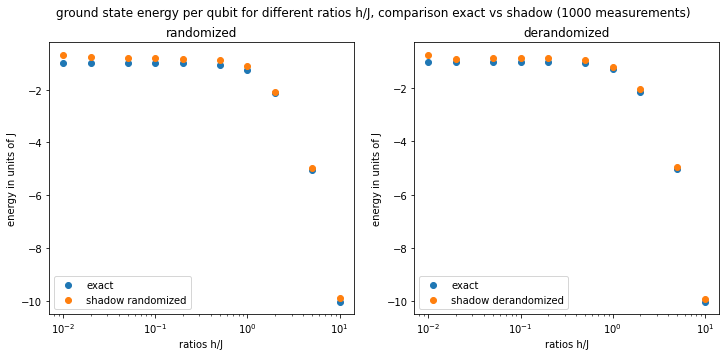

In [4]:
qubit_num = 12
num_of_measurements = 1000
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('ground state energy per qubit for different ratios h/J, comparison exact vs shadow (' + str(num_of_measurements) + ' measurements)')
measurement_methods = ['randomized', 'derandomized']
for i in range(0, 2):
    energy_shadow = np.zeros(np.size(ratios_h_j))
    energy_brute = np.zeros(np.size(ratios_h_j))
    for j in range(0, np.size(ratios_h_j)):
        measurements = measurement_dict[str(qubit_num)][str(ratios_h_j[j])][measurement_methods[i]][0:num_of_measurements]
        energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num, ratios_h_j[j],
                                             1, 'periodic').energy_shadow(None, num_of_measurements, 'derandomized', measurements)
        energy_brute[j] = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[j])][0]
    axs[i].scatter(ratios_h_j[:-3], energy_brute[:-3] / qubit_num, label = 'exact')
    axs[i].scatter(ratios_h_j[:-3], energy_shadow[:-3] / qubit_num, label = 'shadow ' + measurement_methods[i])
    axs[i].set(xscale='log', xlabel='ratios h/J',
                      ylabel='energy in units of J')
    axs[i].set_title(measurement_methods[i])
    axs[i].legend()


Now we plot the error in the ground state per qubit to see whether the shadows perform equally well for all values of
$\frac{h}{J}$. We plot both the relative and the absolute error.

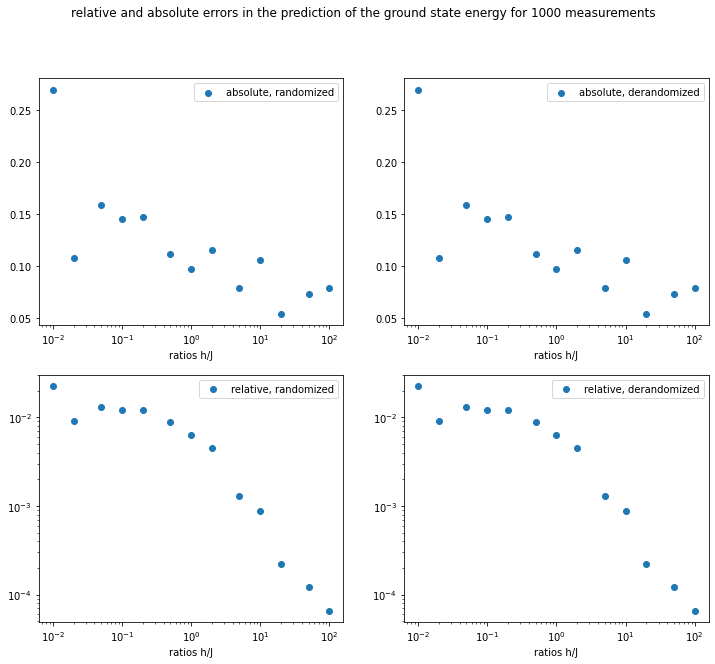

In [5]:
error_types = ['absolute', 'relative']
measurement_methods = ['randomized', 'derandomized']
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('relative and absolute errors in the prediction of the ground state energy for ' + str(num_of_measurements) + ' measurements')
for i in range(0,2):
    for j in range(0,2):
        if error_types[i] == 'absolute':
            error = (energy_shadow - energy_brute) / qubit_num
        if error_types[i] == 'relative':
            error = np.abs(energy_brute - energy_shadow) / qubit_num / np.abs(energy_brute)
        axs[i, j].scatter(ratios_h_j, error, label = error_types[i] + ', ' + measurement_methods[j])
        if error_types[i] == 'absolute':
            axs[i, j].set(xscale='log', xlabel='ratios h/J')
        if error_types[i] == 'relative':
            axs[i, j].set(xscale='log', yscale = 'log', xlabel='ratios h/J')
        axs[i, j].legend()

We can see that the absolute error is almost everywhere bigger than zero.
Other than that it looks pretty much randomly distributed and seems to not depend
on the ratio $\frac{h}{J}$. However, this raises the question whether there is a systematic
error in the code or if the error is intrinsic to the method.
It seems that the classical shadows do not provide an unbiased
estimate of the energy since are not distributed randomly around zero
but around $\approx 0.1$.


 The relative error decreases with increasing $\frac{h}{J}$
which stems from the fact that the energy is increasing.


Now we want to see how the total error scales with the number of measurements
per observable. We focus on the relative error from now on.

We compute the average relative error per qubit number according to the formula:

$\begin{equation}
\Delta E = \frac{1}{N n_r} \sum_{\frac{h}{J}} \frac{|E_{shadow} (\frac{h}{J}) - E_{exact}(\frac{h}{J})|   }{|E_{exact} (\frac{h}{J})|}
\end{equation}$

where N is the number of qubits and $n_r$ the number of different ratios $\frac{h}{J}$.

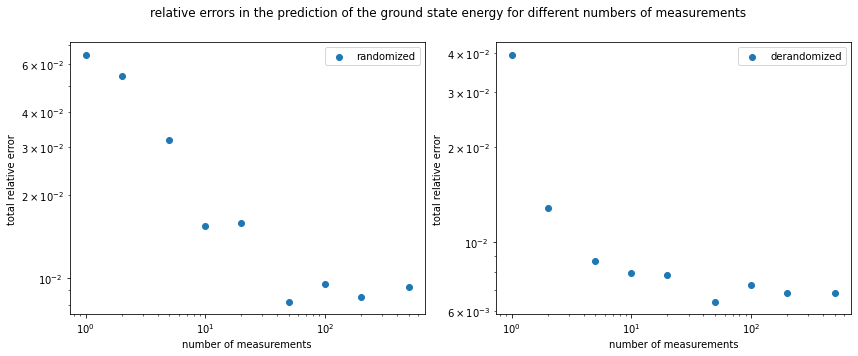

In [31]:
num_of_measurements = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors in the prediction of the ground state energy for different numbers of measurements')
for l in range(0, 2):
    errors = np.zeros(np.size(num_of_measurements))
    for i in range(0, np.size(num_of_measurements)):
        energy_shadow = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            measurements = measurement_dict[str(qubit_num)][str(ratios_h_j[j])][measurement_methods[l]][int(np.sum(num_of_measurements[0:i])):int(np.sum(num_of_measurements[0:i]) + num_of_measurements[i])]
            energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num,
                                                       ratios_h_j[j], 1, 'periodic').energy_shadow(None,
                                                                                                   num_of_measurements[i],
                                                                                                   measurement_methods[l], measurements)
        errors[i] =  np.sum(np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)) / qubit_num / np.size(ratios_h_j)
    axs[l].scatter(num_of_measurements, errors, label = measurement_methods[l])
    axs[l].set(xscale='log', yscale='log', xlabel='number of measurements', ylabel = 'total relative error')
    axs[l].legend()

The method of derandomized measurements converges faster and achieves a smaller
error than the randomized method. However, both stop converging after some number of
measurements. It remains uncertain whether this is an error inherent to the shadow method
itself or whehter there is an error somewhere in this code.


### Comparison Two Point Correlation: shadows vs exact
Now we compute the Two Point Correlation and compare the values computed with the shadows with
the exact values. We compute the Two Point Correlation in the Z basis. It is given by
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$ .
We will only consider the randomized case at first since for this case we can just reuse the
random measurements we already did.

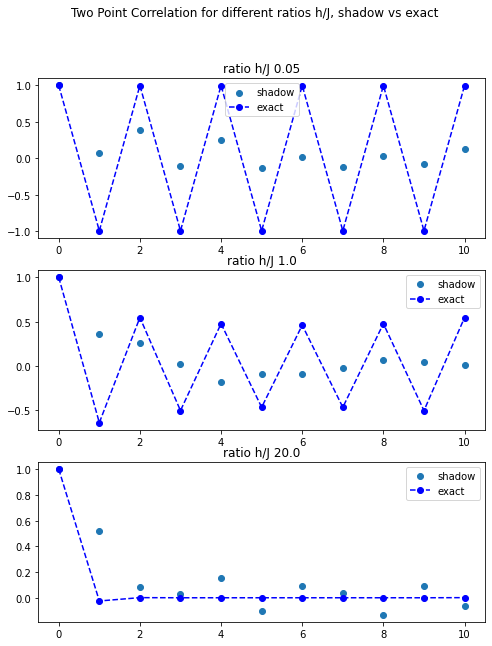

In [24]:
num_of_measurements = 1000
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Two Point Correlation for different ratios h/J, shadow vs exact')
for j in range(0, np.size(some_ratios_h_j)):
    correlation_shadow = np.zeros(qubit_num - 1)
    correlation_brute = np.zeros(qubit_num - 1)
    measurement = measurement_dict[str(qubit_num)][str(some_ratios_h_j[j])]['randomized'][0:num_of_measurements]
    for i in range(0, np.size(correlation_shadow)):
        correlation_shadow[i] = BFQuantumState(qubit_num, None).two_point_correlation_shadow(num_of_measurements, measurement, 'randomized', i, 'Z')
        ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[j])]
        correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
    axs[j].scatter(dist, correlation_shadow, label = 'shadow')
    axs[j].plot(dist, correlation_brute, 'bo', linestyle = 'dashed', label = 'exact')
    axs[j].legend()
    axs[j].set_title('ratio h/J ' + str(some_ratios_h_j[j]))

From this we can see that the shadow prediction follows the overall shape of the curve but
performs very poorly. This raises the question whether we just did not do enough measurements
and the shadow will converge later or whether the randomized measurement method is not
suited in general for this purpose. In the original shadow paper by Preskill and Huang they
perform $10^6$ derandomized measurements to predict the Two Point Correlation. This supports
the hypothesis that we just did not perform enough measurements.
First we will investigate the performance of the
derandomized method for the three cases and then we will check whether the error
converges in the two cases.

First we do the derandomized measurements for the three values of h/J
 and store the outcome since this is the most
computationally expensive part as usual.

In [37]:
qubit_num = 12
num_of_measurements = 500
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
measurement_two_point_correlation_dict = {}

for i in range(0, np.size(some_ratios_h_j)):
    measurement_two_point_correlation_dict[str(some_ratios_h_j[i])] = {}
    ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[i])]
    for j in range(0, qubit_num - 1):
        measurement_two_point_correlation_dict[str(some_ratios_h_j[i])][str(j)] = BFQuantumState(qubit_num,
                                                                                    ground_state).measurement_shadow(num_of_measurements,
                                                                                                                     'derandomized', [[['Z', 0], ['Z', j]]])
np.save(save_direc_measurements_two_point_correlation_derandomized, measurement_two_point_correlation_dict)

In [25]:
#Now we load the measurement data again

measurement_two_point_correlation_dict = np.load(save_direc_measurements_two_point_correlation_derandomized, allow_pickle='TRUE')
measurement_two_point_correlation_dict = measurement_two_point_correlation_dict.item()

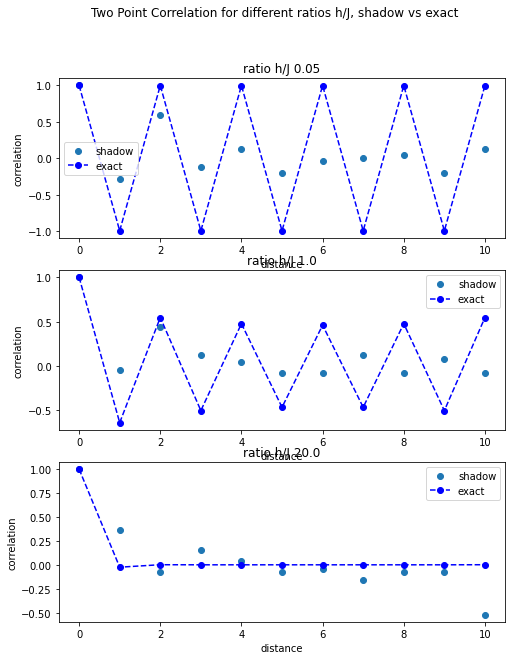

In [54]:
num_of_measurements = 50
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Two Point Correlation for different ratios h/J, shadow vs exact')
for j in range(0, np.size(some_ratios_h_j)):
    correlation_shadow = np.zeros(qubit_num - 1)
    correlation_brute = np.zeros(qubit_num - 1)
    for i in range(0, np.size(correlation_shadow)):
        ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[j])]
        measurement = measurement_two_point_correlation_dict[str(some_ratios_h_j[j])][str(i)][0: num_of_measurements]
        correlation_shadow[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement , 'derandomized', i, 'Z')
        correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
    axs[j].scatter(dist, correlation_shadow, label = 'shadow')
    axs[j].plot(dist, correlation_brute, 'bo', linestyle = 'dashed', label = 'exact')
    axs[j].legend()
    axs[j].set_title('ratio h/J ' + str(some_ratios_h_j[j]))
    axs[j].set(xlabel = 'distance', ylabel = 'correlation')



From now on we focus on the ratio $\frac{h}{J} = 1$ where the phase transition happens
since this is the most interesting area. For this value we investigate how the prediction
accuracy of the shadows scales with the number of measurements.
We compute the average of the absolute error over the different distances.


In [27]:
# one has to load the measurement_two_point_corr_dict before executing this code
# but then the already computed measurements for the other
# values of h/J will not be deleted
qubit_num = 12
num_of_measurements = 500
some_ratios_h_j = np.array([1.0])

for i in range(0, np.size(some_ratios_h_j)):
    measurement_two_point_correlation_dict[str(some_ratios_h_j[i])] = {}
    ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[i])]
    for j in range(0, qubit_num - 1):
        measurement_two_point_correlation_dict[str(some_ratios_h_j[i])][str(j)] = BFQuantumState(qubit_num,
                                                                                    ground_state).measurement_shadow(num_of_measurements,
                                                                                                                     'derandomized', [[['Z', 0], ['Z', j]]])
np.save(save_direc_measurements_two_point_correlation_derandomized, measurement_two_point_correlation_dict)


In [28]:
measurement_two_point_correlation_dict = np.load(save_direc_measurements_two_point_correlation_derandomized, allow_pickle='TRUE')
measurement_two_point_correlation_dict = measurement_two_point_correlation_dict.item()

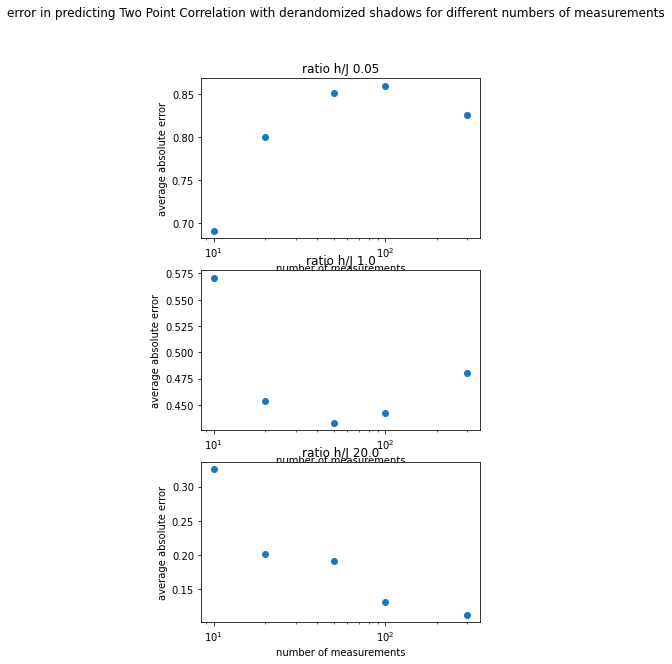

In [50]:
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
num_of_measurements = np.array([10, 20, 50, 100, 300])
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(5)
fig.suptitle('error in predicting Two Point Correlation with derandomized shadows for different numbers of measurements')
for l in range(0, np.size(some_ratios_h_j)):
    errors = np.zeros(np.size(num_of_measurements))
    for j in range(0, np.size(num_of_measurements)):
        correlation_brute = np.zeros(qubit_num - 1)
        correlation_shadow = np.zeros(qubit_num - 1)
        for i in range(0, qubit_num - 1):
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[l])]
            measurement = measurement_two_point_correlation_dict[str(some_ratios_h_j[l])][str(i)][np.sum(num_of_measurements[0:j]):np.sum(num_of_measurements[0:j]) + num_of_measurements[j]]
            correlation_shadow[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement , 'derandomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
        errors[j] = np.sum(np.abs(correlation_brute - correlation_shadow)) / np.size(correlation_brute)
    axs[l].scatter(num_of_measurements, errors)
    axs[l].set_title('ratio h/J ' + str(some_ratios_h_j[l]))
    axs[l].set(xscale='log', xlabel='number of measurements', ylabel = 'average absolute error')

At least for these numbers of measurements no convergence can be detected.
It seems that with more measurements just the amplitude of the oscillation goes down, which
is beneficial for the convergence in the $\frac{h}{J} = 20$ case but for the others not.
Maybe we can observe a convergence for more measurements. I think a much deeper understanding
of the classical shadow theory is required to understand this.
